# This is a file that detect the anomalies inside the dataset

__since use unsupervised learning to detect outliers, there are some considerations:__

1. SVM have complexity of O(n^2), which in this size (150K data) would definitely exceed most hardware capacity since the generation of n*n matrix will take at least 150GB memory
2. Thus, we use isolation forest:

Thus we first use isolation forest(O(nlog(n))) first and meanwhile this can act as a baseline
I first tried to consider do first dimensionality reduction 


__Below are some of the considerations:__
- PCA: work primarily with continious data and work bad with binary one-hot encoded data since it require variance 
- MCA: work directly with categorical data rather than encoded, the large matrix also memory intensive
- random forest: has to be tuned to ensure accuracy. Cross-validation seems infeasible in this context

We finally use truncatedSVD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [26]:
df = pd.read_csv('df_preprocessed2.csv') 

In [27]:
df.shape

(148568, 39)

Text(0.5, 1.0, 'Explained Variance by Component')

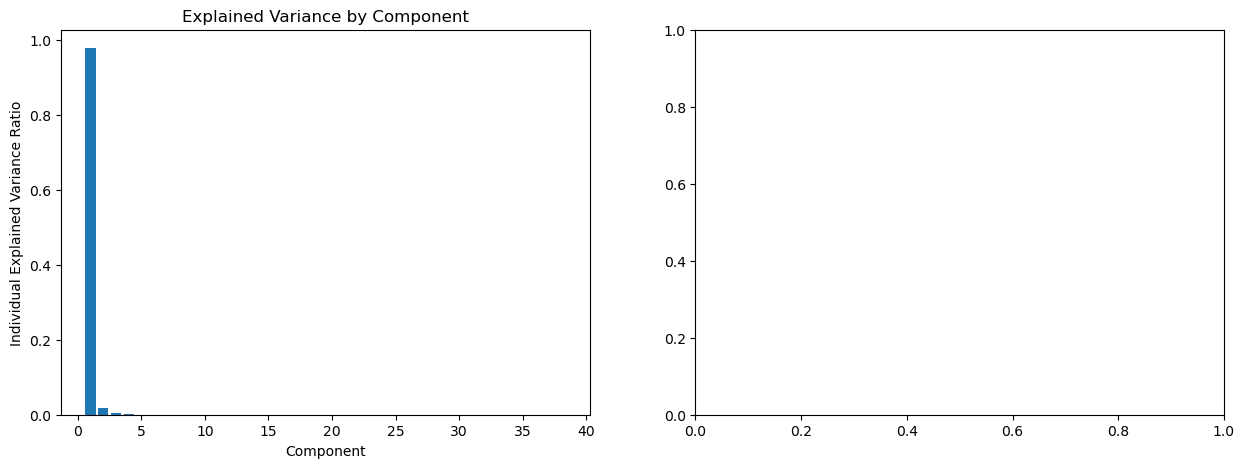

In [28]:
from sklearn.decomposition import TruncatedSVD
import scipy.sparse
from scipy.sparse import csr_matrix

# we can fit with 40 components first, examine the cumulative variance explanation, then set the threshold to make sure effieicnt components
# Use iterable for trial and error is not a good way to go

X = df.drop('DelayClass', axis=1)

if not scipy.sparse.issparse(X): # if dense, put it into a sparse matrix for effciency
    X = csr_matrix(X)

svd = TruncatedSVD(n_components=38, algorithm='randomized', n_iter=5, random_state=42)
reduced_data = svd.fit_transform(X)

# Check explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance)
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
ax1.bar(range(1, len(explained_variance) + 1), explained_variance)
ax1.set_xlabel('Component')
ax1.set_ylabel('Individual Explained Variance Ratio')
ax1.set_title('Explained Variance by Component')

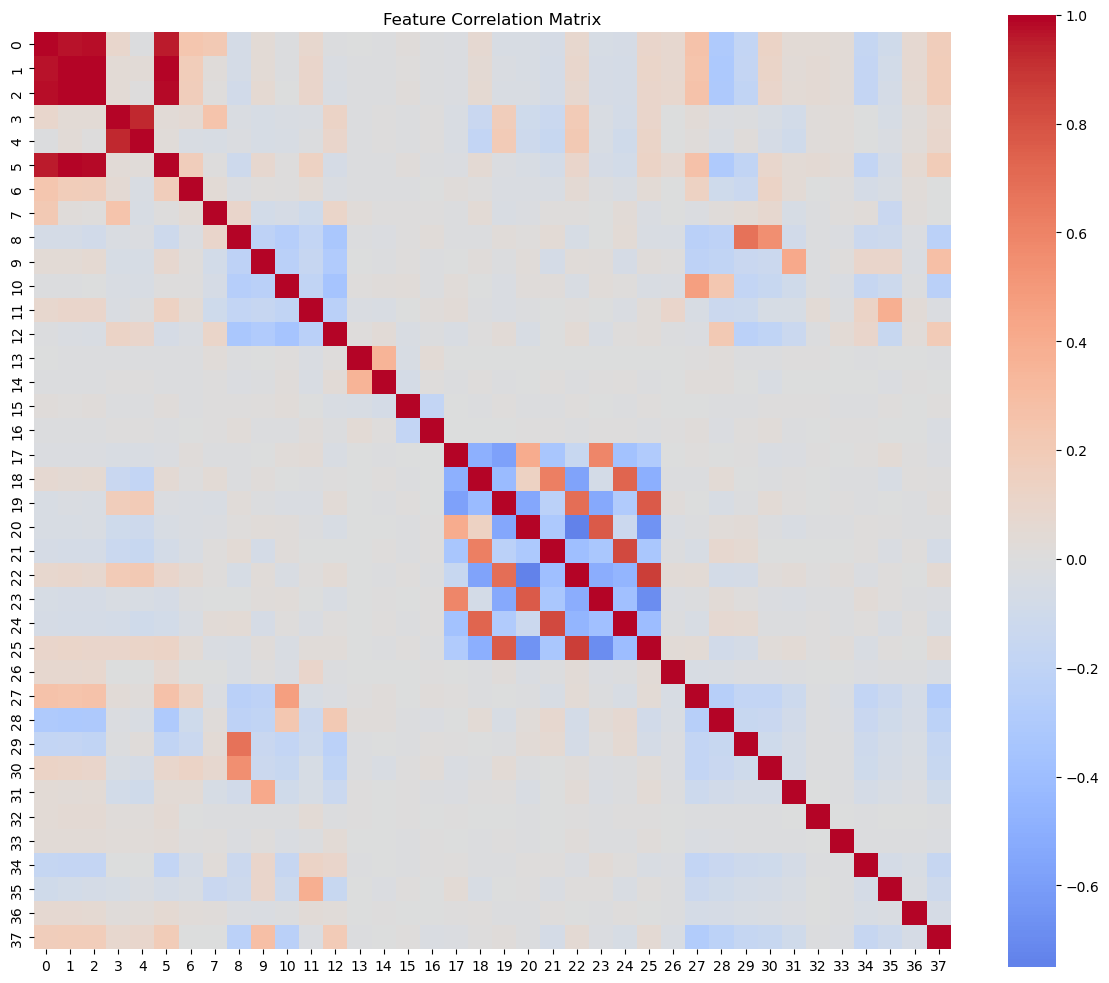

Number of highly correlated pairs: 28


In [29]:
# the result seems quite exterme, which means there are high correlation between features that makes redundancy

X_dense = X.toarray()

correlation_matrix = np.corrcoef(X_dense.T) 

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            cmap='coolwarm',
            center=0,
            square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# see high correlations
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
print("Number of highly correlated pairs:", len(high_corr[0])//2)  # Divide by 2 because of symmetry

In [30]:
# We'll try with 10 components then 

svd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)
reduced_data = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print the cumulative variance for each component
print("\nCumulative variance explained by components:")
for i, cum_var in enumerate(cumulative_variance, 1):
    print(f"Components 1-{i}: {cum_var:.3f}")


Cumulative variance explained by components:
Components 1-1: 0.978
Components 1-2: 0.995
Components 1-3: 0.999
Components 1-4: 1.000
Components 1-5: 1.000
Components 1-6: 1.000
Components 1-7: 1.000
Components 1-8: 1.000
Components 1-9: 1.000
Components 1-10: 1.000


# Reflection

Kind of crazy with this outcome

__Thus, we have to consider the quality of the dataset__
For the record, this dataset is from kaggle and said to be from offical website with 'slight modification' 

Meanwhile, in the past preprocessing:  
- the step of dropping column of destination place may contribute to this situation. However, considering the little contribution of original place, this influence might be trivial.
- The filtering of dataset by choosing top5 airlines may impact, but in terms of overall data, it only diminshes on column of data. Thus, trivial
- the classification of target variable cannot be the issue since this is only conducted among X data

### However, high correlation does not necessarily mean the dominant components can be predicative (its about interaction with target variable)

- dimensionality reduction (in this case, linear combintation of features) not equal to feature selection
- However, redundancy is indeed existing

Thus, keep first 10 components for the random forest to get the importance (the computation would be good)

In [31]:
print(reduced_data.shape[0] == df.shape[0]) # ensure they has same dimensions (secure the later comparison)

True


In [32]:
# store it back into pd df (reduced_data is np.ndarray)
# We need to compare values in the reduce_data with original df to then retreive names from df and fill in new dataset

df2 = pd.DataFrame()

for col1 in df.columns:
    original_values = df[col1].iloc[:1001].values
    
    for col2_index in range(reduced_data.shape[1]):  # Iterate over columns of reduced_data_sample
        compared_values = reduced_data[:1001, col2_index]
        
        if np.array_equal(original_values, compared_values):
            # Assign matching column to df2
            df2[f'{col1}({col2_index})'] = reduced_data[:1001, col2_index]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [33]:
# remainder that the outcome of SVD is linear combination of features rather than original feature values
# For better performance, interpretability is sacrifised and use components for later work

X = X.toarray()
col_names  = [f'PC{i+1}' for i in range(10)]

df2  = pd.DataFrame(
    data = reduced_data,
    columns = col_names
)

df2['Class'] = df['DelayClass']

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148568 entries, 0 to 148567
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC1     148568 non-null  float64
 1   PC2     148568 non-null  float64
 2   PC3     148568 non-null  float64
 3   PC4     148568 non-null  float64
 4   PC5     148568 non-null  float64
 5   PC6     148568 non-null  float64
 6   PC7     148568 non-null  float64
 7   PC8     148568 non-null  float64
 8   PC9     148568 non-null  float64
 9   PC10    148568 non-null  float64
 10  Class   148568 non-null  object 
dtypes: float64(10), object(1)
memory usage: 12.5+ MB


In [10]:
# Now do the random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.inspection import permutation_importance
import shap
from joblib import parallel_backend
import time

X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state=42) # Split dataset into 75% train and 25% test
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
base_clf.fit(X_train, y_train)
baseline_time = time.time() - start_time

y_predict = base_clf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_predict)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Model Training Time: {baseline_time:.2f} seconds")
# We first has a base model to have an estimation of run time and computation burden
# We'll optimize later and use best set to get the importance

/home/hty/anaconda3/envs/CV_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Baseline Model Accuracy: 0.6517
Baseline Model Training Time: 38.97 seconds


In [13]:
# Time seems good, we first used grid search, it did not end with 2hr of 20CPU running. Thus, modify the code 
# Note that parallel computing is used. Device with limited hardware might take more time

import os
import optuna
from sklearn.model_selection import cross_val_score
from joblib import parallel_backend

class EfficientFeatureImportance:
    def __init__(self, X, y, n_trials=30):
        self.X = X
        self.y = y
        self.n_trials = n_trials
        self.model = None
        self.feature_names = X.columns
        self.trial_history = []  # Store trial results
        
    def objective(self, trial):

        # constrained parameter space to reduce computation
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),  
            'max_depth': trial.suggest_int('max_depth', 5, 20, step=5),          
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),   
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3)     
        }
        
        start_time = time.time()
        
        model = RandomForestClassifier(
            **param,
            random_state=42,
            n_jobs=-1  # Use all CPU cores
        )
        
        # Use 3-fold CV instead of 5-fold to reduce computation
        scores = cross_val_score(model, self.X, self.y, cv=3, scoring='accuracy')
        
        training_time = time.time() - start_time
        mean_score = scores.mean()
        
        # Store trial information
        self.trial_history.append({
            'params': param,
            'score': mean_score,
            'training_time': training_time
        })
        
        return mean_score

    def HyperparameterTuning(self):

        # Add pruner to stop unpromising trials early
        pruner = optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5
        )
        
        study = optuna.create_study(
            direction='maximize',
            pruner=pruner
        )
        
        print("Starting hyperparameter optimization...")
        study.optimize(self.objective, n_trials=self.n_trials)
        
        # Analyze and print trial statistics
        print("\nHyperparameter Optimization Results:")
        print(f"Best parameters: {study.best_params}")
        print(f"Best accuracy: {study.best_value:.4f}")
        
        # Calculate and display computational statistics
        trial_times = [trial['training_time'] for trial in self.trial_history]
        print(f"\nComputational Statistics:")
        print(f"Average trial time: {np.mean(trial_times):.2f} seconds")
        print(f"Total optimization time: {sum(trial_times):.2f} seconds")
        
        # Train final model with best parameters
        print("\nTraining final model with best parameters...")
        start_time = time.time()
        self.model = RandomForestClassifier(
            **study.best_params,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X, self.y)
        final_training_time = time.time() - start_time
        print(f"Final model training time: {final_training_time:.2f} seconds")
        
        # Create performance summary
        performance_summary = pd.DataFrame(self.trial_history)
        performance_summary['n_estimators'] = performance_summary['params'].apply(lambda x: x['n_estimators'])
        performance_summary['max_depth'] = performance_summary['params'].apply(lambda x: x['max_depth'])
        
        # Plot parameter impact on performance
        self.PlotParameterImpact(performance_summary)
        
        return study.best_params, performance_summary
    
    def PlotParameterImpact(self, performance_summary):
        plt.figure(figsize=(15, 5))
        
        # Plot 1: n_estimators vs score
        plt.subplot(1, 2, 1)
        plt.scatter(performance_summary['n_estimators'], 
                   performance_summary['score'], 
                   alpha=0.6)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy Score')
        plt.title('Impact of n_estimators on Performance')
        
        # Plot 2: max_depth vs score
        plt.subplot(1, 2, 2)
        plt.scatter(performance_summary['max_depth'], 
                   performance_summary['score'], 
                   alpha=0.6)
        plt.xlabel('Max Depth')
        plt.ylabel('Accuracy Score')
        plt.title('Impact of max_depth on Performance')
        
        plt.tight_layout()
        plt.show()
    
    def CalculateImportance(self):
        print("\nCalculating feature importance metrics...")
        
        start_time = time.time()
        
        # Gini Importance (fastest)
        gini_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        gini_time = time.time() - start_time
        start_time = time.time()
        
        # Permutation Importance (reduced repeats)
        with parallel_backend('threading', n_jobs=-1):
            perm_importance = permutation_importance(
                self.model, self.X, self.y,
                n_repeats=5,  # Reduced from 10
                random_state=42
            )
        
        perm_time = time.time() - start_time
        start_time = time.time()
        
        perm_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': perm_importance.importances_mean
        }).sort_values('importance', ascending=False)
        
        ''' #SHAP is too computationally complicated
        # SHAP Importance (most computationally intensive)
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X)
        if isinstance(shap_values, list):
            shap_values = np.abs(np.array(shap_values)).mean(axis=0).mean(axis=0)
        else:
            shap_values = np.abs(shap_values).mean(axis=0)
        
        shap_time = time.time() - start_time
        
        shap_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': shap_values
        }).sort_values('importance', ascending=False)
        
        print(f"\nComputation times:")
        print(f"Gini importance: {gini_time:.2f} seconds")
        print(f"Permutation importance: {perm_time:.2f} seconds")
        print(f"SHAP importance: {shap_time:.2f} seconds")
        '''

        return gini_importance, perm_importance_df
    
    def ImportanceVisualization(self, gini_importance, perm_importance):
        gini_normalized = gini_importance.copy()
        perm_normalized = perm_importance.copy()
        
        gini_normalized['importance'] = (gini_normalized['importance'] - 
                                    gini_normalized['importance'].min()) / \
                                    (gini_normalized['importance'].max() - 
                                    gini_normalized['importance'].min())
        
        perm_normalized['importance'] = (perm_normalized['importance'] - 
                                    perm_normalized['importance'].min()) / \
                                    (perm_normalized['importance'].max() - 
                                    perm_normalized['importance'].min())
        
        # Combine both importance scores
        summary_df = pd.DataFrame({
            'Feature': gini_normalized['feature'],
            'Gini_Importance': gini_normalized['importance'],
            'Permutation_Importance': perm_normalized['importance']
        })
        
        # Calculate mean importance
        summary_df['Mean_Importance'] = summary_df[['Gini_Importance', 
                                                'Permutation_Importance']].mean(axis=1)
        
        # Sort by mean importance
        summary_df = summary_df.sort_values('Mean_Importance', ascending=False)
        
        return summary_df

[I 2024-12-12 05:06:01,181] A new study created in memory with name: no-name-25a85807-eec9-4c40-a40d-e80a8f815bbb


Starting hyperparameter optimization...


[I 2024-12-12 05:06:07,097] Trial 0 finished with value: 0.629967498676928 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.629967498676928.
[I 2024-12-12 05:06:17,798] Trial 1 finished with value: 0.6296511413716086 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.629967498676928.
[I 2024-12-12 05:06:20,707] Trial 2 finished with value: 0.5797480353292377 and parameters: {'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.629967498676928.
[I 2024-12-12 05:06:29,901] Trial 3 finished with value: 0.6408244775916657 and parameters: {'n_estimators': 125, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.6408244775916657.
[I 2024-12-12 05:06:36,191] Trial 4 finished with value: 0.6299001843117854 and parameters: {'n_es


Hyperparameter Optimization Results:
Best parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best accuracy: 0.6447

Computational Statistics:
Average trial time: 12.51 seconds
Total optimization time: 375.36 seconds

Training final model with best parameters...
Final model training time: 9.67 seconds


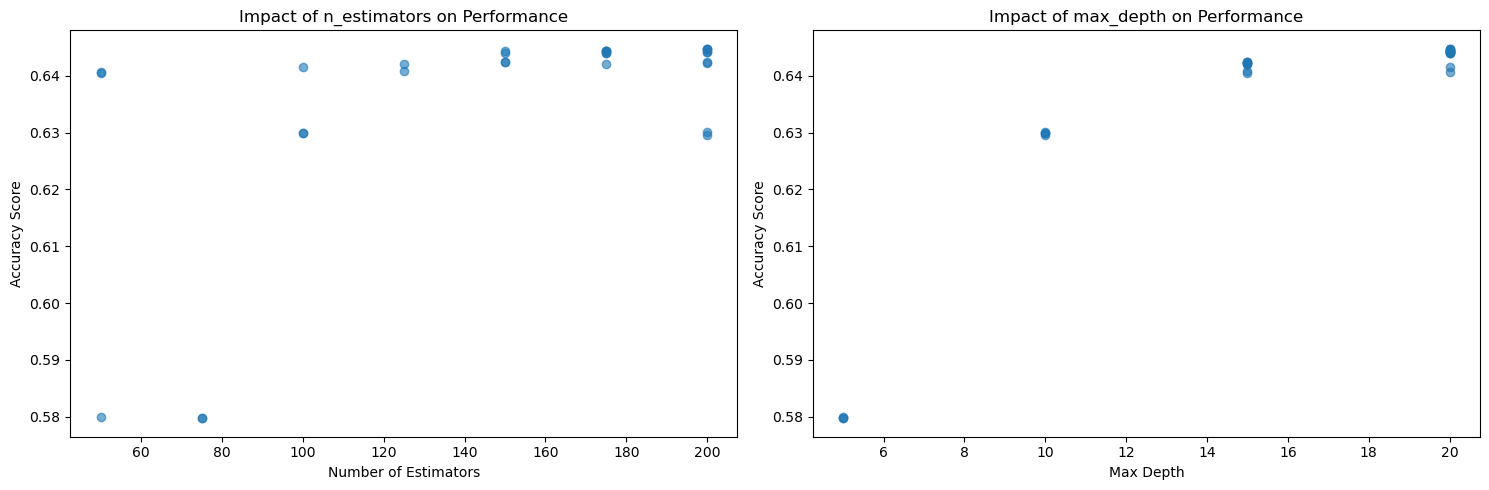


Calculating feature importance metrics...

Feature Importance Summary (normalized):
  Feature  Mean_Importance
1     PC2         1.000000
0     PC1         0.382370
3     PC4         0.345892
2     PC3         0.273995
4     PC5         0.210270
7     PC8         0.107580
6     PC7         0.090377
5     PC6         0.016784
9    PC10         0.003017
8     PC9         0.001415


In [14]:
analyzer = EfficientFeatureImportance(X=df2.iloc[:, :-1], y=df2.iloc[:, -1])

best_params = analyzer.HyperparameterTuning()

gini_importance, perm_importance = analyzer.CalculateImportance()

summary_df = analyzer.ImportanceVisualization(gini_importance, perm_importance)

print("\nFeature Importance Summary (normalized):")
print(summary_df[['Feature', 'Mean_Importance']].to_string())

### Interpretations

- It can be seen that the optimal performance of the model is no better than default configuration, which is:
estimators: 100  
random_state: 42  
max_depth: None (unlimited)  
min_samples_split: 2  
min_samples_leaf: 1  

- potential reasons:
1. depth limitation
2. leaf size: smaller leaf size allow model to make more specific rule, which might catch more info 
3. limited hyperparameter searching space: although the many settings in the default is in the search space, there is no significant improvement within searching. This might indicate there are values outside outperforms 
4. dataset does not actual have the value to study

- Now we'll go with the top5 features for anomaly detection

Although it can be seen that there is little value to go on the study since the performance is so far not ideal, due to time limitation, we stick with current dataset

At least so fat there is an intuition that the result of unsupervised dimensionality reduction align mostly supervised feature selection methods  
__which reflect the feasibility of methods (correlation detected between features can be directly applied to feature engineering)__

In [36]:
# cut the df2 dataset

selected_features = summary_df['Feature'].iloc[:5].tolist()

selected_features.append('Class')

df2 = df2[selected_features]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148568 entries, 0 to 148567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC2     148568 non-null  float64
 1   PC1     148568 non-null  float64
 2   PC4     148568 non-null  float64
 3   PC3     148568 non-null  float64
 4   PC5     148568 non-null  float64
 5   Class   148568 non-null  object 
dtypes: float64(5), object(1)
memory usage: 6.8+ MB


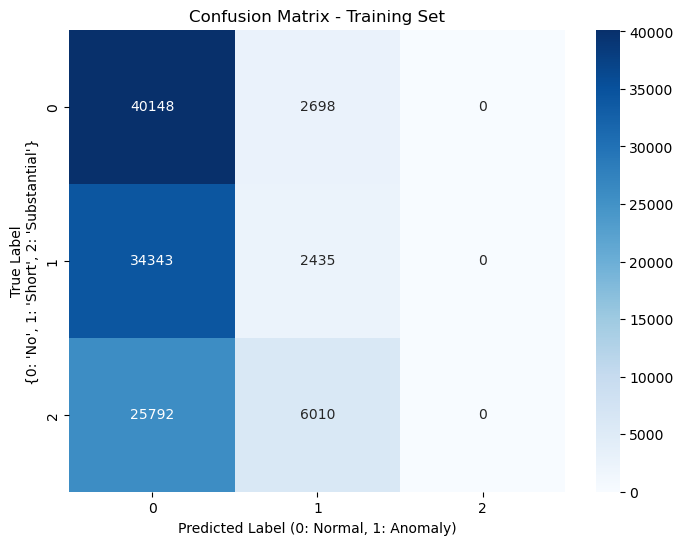

Training Set Results:

Class Mapping: {0: 'No', 1: 'Short', 2: 'Substantial'}

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.94      0.56     42846
           1       0.22      0.07      0.10     36778
           2       0.00      0.00      0.00     31802

    accuracy                           0.38    111426
   macro avg       0.21      0.33      0.22    111426
weighted avg       0.23      0.38      0.25    111426


Number of detected anomalies: 11143
Percentage of anomalies: 10.00%


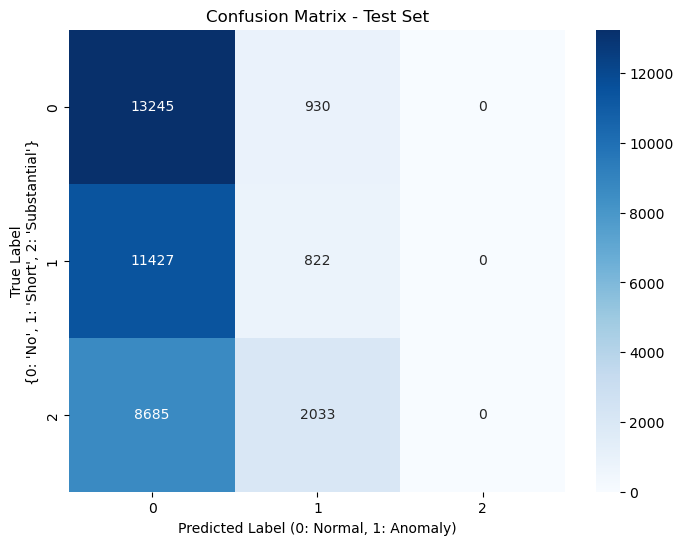


Test Set Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.93      0.56     14175
           1       0.22      0.07      0.10     12249
           2       0.00      0.00      0.00     10718

    accuracy                           0.38     37142
   macro avg       0.20      0.33      0.22     37142
weighted avg       0.22      0.38      0.25     37142


Number of detected anomalies: 3785
Percentage of anomalies: 10.19%


In [48]:
# Use isolation forest to detect anomaly 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]

# Encode categorical labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use encoded labels for train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

clf = IsolationForest(random_state=42, contamination=0.1, n_jobs=-1)
clf.fit(X_train)

# the prediction, 1 for normal, -1 for anomaly
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Convert predictions to binary (0 for outliers, 1 for inliers)
y_pred_train_binary = np.where(y_pred_train == 1, 0, 1)
y_pred_test_binary = np.where(y_pred_test == 1, 0, 1)

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
cm_train = confusion_matrix(y_train, y_pred_train_binary)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.ylabel(f'True Label\n{dict(enumerate(le.classes_))}')
plt.xlabel('Predicted Label (0: Normal, 1: Anomaly)')
plt.show()

# Print training set metrics
print("Training Set Results:")
print("\nClass Mapping:", dict(enumerate(le.classes_)))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train_binary))
print(f"\nNumber of detected anomalies: {sum(y_pred_train_binary == 1)}")
print(f"Percentage of anomalies: {(sum(y_pred_train_binary == 1)/len(y_pred_train_binary))*100:.2f}%")

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test_binary)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel(f'True Label\n{dict(enumerate(le.classes_))}')
plt.xlabel('Predicted Label (0: Normal, 1: Anomaly)')
plt.show()

# Print test set metrics
print("\nTest Set Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_binary))
print(f"\nNumber of detected anomalies: {sum(y_pred_test_binary == 1)}")
print(f"Percentage of anomalies: {(sum(y_pred_test_binary == 1)/len(y_pred_test_binary))*100:.2f}%")

Notice that there is a mismatch between dimension of anomaly (binary: 0 or 1) and dimension print in heatmap (3 in an axis)

that is because the target variable is a 3-class categorical variable. It indicates that isolation forest should work with regression problem

one-class SVM might fit the context, but as mentioned might not feasible in this study

- There is a trend that with higher contanmination percentage(% of anomaly in the dataset), the precision is higher
- This can be explained that the confusion matrix already shows large amount of anomalies in the dataset, which indicates there are actually that many. Thus, more pre-defined proportion, higher the precision

__this dataset is truly not what we want__  
in future work, some tests needed to be done to ensure the worth of dataset   
or may be with deeper DS knowledge, this can be explaioned to be real in some way/ with some processing

We'll go with 10% and delete some of the anomalies

In [ ]:
# Only need to filter the dataset

full_predictions = clf.predict(X)

df2_clean = df2[full_predictions == 1]

df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133640 entries, 0 to 148567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC2     133640 non-null  float64
 1   PC1     133640 non-null  float64
 2   PC4     133640 non-null  float64
 3   PC3     133640 non-null  float64
 4   PC5     133640 non-null  float64
 5   Class   133640 non-null  object 
dtypes: float64(5), object(1)
memory usage: 7.1+ MB


In [50]:
df2_clean.to_csv('df_preprocessed3.csv', index=False) # Store to for the next step of model training